<a href="https://colab.research.google.com/github/abksyed/EVA4/blob/master/10_Training_LearningRates/Assignment_S10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Repository github url : https://github.com/jai-mr/
# Assignment Repository : https://github.com/jai-mr/Assignment-10
# Submitted by : Jaideep Rangnekar
# Registered email id : jaideepmr@gmail.com

In [2]:
# Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
from google.colab import drive
drive.mount("/content/gdrive")
gdrivepath="gdrive/My Drive/Colab Notebooks/S10/"

Mounted at /content/gdrive


In [3]:
!rm *.py 
!ls
print("-----------------------------------------!")
!ls "gdrive/My Drive/Colab Notebooks/S10/packages"

rm: cannot remove '*.py': No such file or directory
gdrive	sample_data
-----------------------------------------!
augmentation.py  data.py      data_summary.py  gradCAM.py  plot.py  train.py
CusResNet.py	 datasets.py  find_lr.py       graphs.py   test.py


In [4]:
!cp "gdrive/My Drive/Colab Notebooks/S10/packages/augmentation.py" augmentation.py
!cp "gdrive/My Drive/Colab Notebooks/S10/packages/CusResNet.py" CusResNet.py
!cp "gdrive/My Drive/Colab Notebooks/S10/packages/data_summary.py" data_summary.py
!cp "gdrive/My Drive/Colab Notebooks/S10/packages/data.py" data.py
!cp "gdrive/My Drive/Colab Notebooks/S10/packages/datasets.py" datasets.py
!cp "gdrive/My Drive/Colab Notebooks/S10/packages/test.py" test.py
!cp "gdrive/My Drive/Colab Notebooks/S10/packages/train.py" train.py
!cp "gdrive/My Drive/Colab Notebooks/S10/packages/find_lr.py" find_lr.py
!cp "gdrive/My Drive/Colab Notebooks/S10/packages/plot.py" plot.py
!cp "gdrive/My Drive/Colab Notebooks/S10/packages/graphs.py" graphs.py
!cp "gdrive/My Drive/Colab Notebooks/S10/packages/gradCAM.py" gradCAM.py
!ls 

augmentation.py  datasets.py	  gdrive      plot.py	   train.py
CusResNet.py	 data_summary.py  gradCAM.py  sample_data
data.py		 find_lr.py	  graphs.py   test.py


In [5]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For Reproducibility
torch.manual_seed(1)

if cuda:
    torch.cuda.manual_seed(1)
print(torch.cuda.get_device_name(0))

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

CUDA Available? True
Tesla P100-PCIE-16GB


In [6]:
from  CusResNet import CusResNet18
model = CusResNet18().to(device)

In [7]:
!pip install torchsummary
import data_summary as ds

ds.model_summary(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [8]:
from augmentation import CIFAR10_AlbumTrans

In [9]:
from data import CIFAR10DataLoader

In [10]:
trans = CIFAR10_AlbumTrans() 
data = CIFAR10DataLoader(trans, batch_size= 128)
train_loader, test_loader = data.get_loaders()

Extracting ./root/cifar-10-python.tar.gz to ./root
Files already downloaded and verified


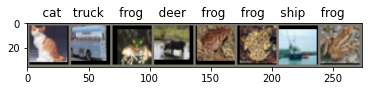

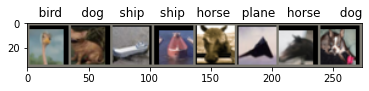

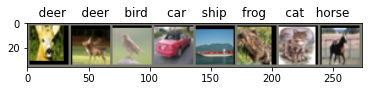

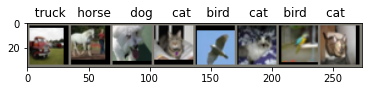

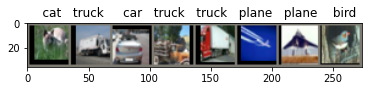

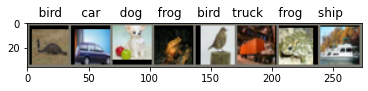

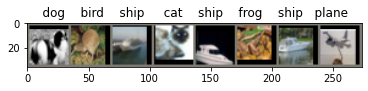

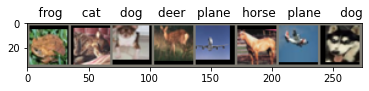

In [11]:
ds.display(train_loader, 64)

In [12]:
from find_lr import LRFinder
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr= 1e-7, momentum= 0.9)
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=100, num_iter=100, step_mode="exp")

  pip install torch-lr-finder -v --global-option="amp"


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


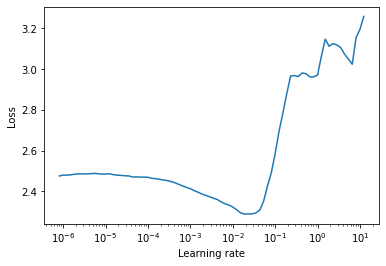

In [13]:
lr_finder.plot()

In [14]:
print('Least Loss(FastAI Approach) : ', min(lr_finder.history['loss']))
best_lr = lr_finder.history['lr'][lr_finder.history['loss'].index(
    min(lr_finder.history['loss'])
)]
print('Best lr(FastAI Approach) : ', best_lr)


Least Loss(FastAI Approach) :  2.288162232641284
Best lr(FastAI Approach) :  0.01873817422860384


In [15]:
lr_finder.reset()

In [16]:
from train import Train
from test import Test
from torch.optim.lr_scheduler import ReduceLROnPlateau

model = CusResNet18().to(device)
optimizer = optim.SGD(model.parameters(), lr= best_lr, momentum= 0.9)
criterion = nn.CrossEntropyLoss()
train = Train( model, device, train_loader, optimizer, criterion)
test = Test(model, device, test_loader, criterion)
test_acc = test.test_acc
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=3, verbose= True, threshold=0.1, threshold_mode= 'abs')

In [17]:
lr_list = []
epochs = 50
print('='*20 + 'START' + '='*20)
for epoch in range(epochs):
  print('='*20 + f' EPOCH: {epoch+1} ' + '='*20)
  train.train(epoch)
  lr_list.append(optimizer.param_groups[0]['lr'])
  test.test()
  scheduler.step(test.test_acc[-1]) #Have to give the val_loss or val_accuracy here. 
                                    #The metric on which we check reduction/increase 
                                    #and adjust learing rate

  0%|          | 0/391 [00:00<?, ?it/s]

====================START====================
==================== EPOCH: 1 ====================


Loss=1.3710906505584717 Batch_id=390 Accuracy=45.33: 100%|██████████| 391/391 [00:32<00:00, 12.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0102, Accuracy: 5395/10000 (53.95%)

==================== EPOCH: 2 ====================


Loss=0.8720309138298035 Batch_id=390 Accuracy=65.82: 100%|██████████| 391/391 [00:32<00:00, 12.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0077, Accuracy: 6856/10000 (68.56%)

==================== EPOCH: 3 ====================


Loss=0.9131757616996765 Batch_id=390 Accuracy=74.75: 100%|██████████| 391/391 [00:32<00:00, 12.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0062, Accuracy: 7366/10000 (73.66%)

==================== EPOCH: 4 ====================


Loss=0.49944648146629333 Batch_id=390 Accuracy=79.34: 100%|██████████| 391/391 [00:32<00:00, 12.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 7620/10000 (76.20%)

==================== EPOCH: 5 ====================


Loss=0.702536940574646 Batch_id=390 Accuracy=82.07: 100%|██████████| 391/391 [00:32<00:00, 12.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 7486/10000 (74.86%)

==================== EPOCH: 6 ====================


Loss=0.4358326494693756 Batch_id=390 Accuracy=84.24: 100%|██████████| 391/391 [00:32<00:00, 12.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 8036/10000 (80.36%)

==================== EPOCH: 7 ====================


Loss=0.36653298139572144 Batch_id=390 Accuracy=86.12: 100%|██████████| 391/391 [00:32<00:00, 12.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8106/10000 (81.06%)

==================== EPOCH: 8 ====================


Loss=0.35451841354370117 Batch_id=390 Accuracy=87.28: 100%|██████████| 391/391 [00:32<00:00, 12.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8532/10000 (85.32%)

==================== EPOCH: 9 ====================


Loss=0.5079140663146973 Batch_id=390 Accuracy=88.59: 100%|██████████| 391/391 [00:32<00:00, 12.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8634/10000 (86.34%)

==================== EPOCH: 10 ====================


Loss=0.4029472768306732 Batch_id=390 Accuracy=89.17: 100%|██████████| 391/391 [00:32<00:00, 12.18it/s]



Test set: Average loss: 0.0031, Accuracy: 8705/10000 (87.05%)



  0%|          | 0/391 [00:00<?, ?it/s]

==================== EPOCH: 11 ====================


Loss=0.2575770616531372 Batch_id=390 Accuracy=90.38: 100%|██████████| 391/391 [00:32<00:00, 12.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8663/10000 (86.63%)

==================== EPOCH: 12 ====================


Loss=0.32020193338394165 Batch_id=390 Accuracy=91.00: 100%|██████████| 391/391 [00:32<00:00, 12.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8611/10000 (86.11%)

==================== EPOCH: 13 ====================


Loss=0.26489004492759705 Batch_id=390 Accuracy=91.73: 100%|██████████| 391/391 [00:32<00:00, 12.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8692/10000 (86.92%)

==================== EPOCH: 14 ====================


Loss=0.22764229774475098 Batch_id=390 Accuracy=92.10: 100%|██████████| 391/391 [00:32<00:00, 12.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8906/10000 (89.06%)

==================== EPOCH: 15 ====================


Loss=0.24937739968299866 Batch_id=390 Accuracy=92.77: 100%|██████████| 391/391 [00:32<00:00, 12.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 8834/10000 (88.34%)

==================== EPOCH: 16 ====================


Loss=0.2574121057987213 Batch_id=390 Accuracy=93.27: 100%|██████████| 391/391 [00:32<00:00, 12.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 8906/10000 (89.06%)

==================== EPOCH: 17 ====================


Loss=0.17383788526058197 Batch_id=390 Accuracy=93.81: 100%|██████████| 391/391 [00:32<00:00, 12.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 8901/10000 (89.01%)

==================== EPOCH: 18 ====================


Loss=0.0952564924955368 Batch_id=390 Accuracy=94.38: 100%|██████████| 391/391 [00:32<00:00, 12.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 9002/10000 (90.02%)

==================== EPOCH: 19 ====================


Loss=0.1670909821987152 Batch_id=390 Accuracy=94.73: 100%|██████████| 391/391 [00:32<00:00, 12.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 9003/10000 (90.03%)

==================== EPOCH: 20 ====================


Loss=0.13946016132831573 Batch_id=390 Accuracy=94.91: 100%|██████████| 391/391 [00:32<00:00, 12.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8894/10000 (88.94%)

==================== EPOCH: 21 ====================


Loss=0.04983166977763176 Batch_id=390 Accuracy=95.43: 100%|██████████| 391/391 [00:32<00:00, 12.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 8918/10000 (89.18%)

==================== EPOCH: 22 ====================


Loss=0.06553611159324646 Batch_id=390 Accuracy=95.45: 100%|██████████| 391/391 [00:32<00:00, 12.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8964/10000 (89.64%)

Epoch    22: reducing learning rate of group 0 to 1.8738e-03.
==================== EPOCH: 23 ====================


Loss=0.04917029291391373 Batch_id=390 Accuracy=97.69: 100%|██████████| 391/391 [00:32<00:00, 12.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9217/10000 (92.17%)

==================== EPOCH: 24 ====================


Loss=0.026111045852303505 Batch_id=390 Accuracy=98.31: 100%|██████████| 391/391 [00:32<00:00, 12.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9215/10000 (92.15%)

==================== EPOCH: 25 ====================


Loss=0.033494047820568085 Batch_id=390 Accuracy=98.65: 100%|██████████| 391/391 [00:32<00:00, 12.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9218/10000 (92.18%)

==================== EPOCH: 26 ====================


Loss=0.03140174224972725 Batch_id=390 Accuracy=98.75: 100%|██████████| 391/391 [00:32<00:00, 12.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9241/10000 (92.41%)

==================== EPOCH: 27 ====================


Loss=0.010127685964107513 Batch_id=390 Accuracy=98.86: 100%|██████████| 391/391 [00:32<00:00, 12.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9245/10000 (92.45%)

==================== EPOCH: 28 ====================


Loss=0.01823081448674202 Batch_id=390 Accuracy=98.96: 100%|██████████| 391/391 [00:32<00:00, 12.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9242/10000 (92.42%)

==================== EPOCH: 29 ====================


Loss=0.018062420189380646 Batch_id=390 Accuracy=98.99: 100%|██████████| 391/391 [00:32<00:00, 12.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9251/10000 (92.51%)

==================== EPOCH: 30 ====================


Loss=0.06007201597094536 Batch_id=390 Accuracy=99.12: 100%|██████████| 391/391 [00:32<00:00, 12.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9255/10000 (92.55%)

==================== EPOCH: 31 ====================


Loss=0.050585031509399414 Batch_id=390 Accuracy=99.18: 100%|██████████| 391/391 [00:32<00:00, 12.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9250/10000 (92.50%)

==================== EPOCH: 32 ====================


Loss=0.030021529644727707 Batch_id=390 Accuracy=99.21: 100%|██████████| 391/391 [00:32<00:00, 12.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9262/10000 (92.62%)

==================== EPOCH: 33 ====================


Loss=0.011415784247219563 Batch_id=390 Accuracy=99.23: 100%|██████████| 391/391 [00:32<00:00, 12.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9231/10000 (92.31%)

==================== EPOCH: 34 ====================


Loss=0.03258537873625755 Batch_id=390 Accuracy=99.29: 100%|██████████| 391/391 [00:32<00:00, 12.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9248/10000 (92.48%)

==================== EPOCH: 35 ====================


Loss=0.06688384711742401 Batch_id=390 Accuracy=99.37: 100%|██████████| 391/391 [00:32<00:00, 12.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 9227/10000 (92.27%)

==================== EPOCH: 36 ====================


Loss=0.011229702271521091 Batch_id=390 Accuracy=99.37: 100%|██████████| 391/391 [00:32<00:00, 12.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9235/10000 (92.35%)

Epoch    36: reducing learning rate of group 0 to 1.8738e-04.
==================== EPOCH: 37 ====================


Loss=0.015045898035168648 Batch_id=390 Accuracy=99.38: 100%|██████████| 391/391 [00:32<00:00, 12.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9264/10000 (92.64%)

==================== EPOCH: 38 ====================


Loss=0.05156352370977402 Batch_id=390 Accuracy=99.44: 100%|██████████| 391/391 [00:32<00:00, 12.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9258/10000 (92.58%)

==================== EPOCH: 39 ====================


Loss=0.02983943000435829 Batch_id=390 Accuracy=99.46: 100%|██████████| 391/391 [00:32<00:00, 12.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9268/10000 (92.68%)

==================== EPOCH: 40 ====================


Loss=0.009604943916201591 Batch_id=390 Accuracy=99.52: 100%|██████████| 391/391 [00:32<00:00, 12.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9255/10000 (92.55%)

Epoch    40: reducing learning rate of group 0 to 1.8738e-05.
==================== EPOCH: 41 ====================


Loss=0.015110684558749199 Batch_id=390 Accuracy=99.46: 100%|██████████| 391/391 [00:32<00:00, 12.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9258/10000 (92.58%)

==================== EPOCH: 42 ====================


Loss=0.023371638730168343 Batch_id=390 Accuracy=99.52: 100%|██████████| 391/391 [00:32<00:00, 12.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9252/10000 (92.52%)

==================== EPOCH: 43 ====================


Loss=0.026646355167031288 Batch_id=390 Accuracy=99.50: 100%|██████████| 391/391 [00:32<00:00, 12.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9257/10000 (92.57%)

==================== EPOCH: 44 ====================


Loss=0.006293075624853373 Batch_id=390 Accuracy=99.50: 100%|██████████| 391/391 [00:32<00:00, 12.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9260/10000 (92.60%)

Epoch    44: reducing learning rate of group 0 to 1.8738e-06.
==================== EPOCH: 45 ====================


Loss=0.011070088483393192 Batch_id=390 Accuracy=99.48: 100%|██████████| 391/391 [00:32<00:00, 11.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9258/10000 (92.58%)

==================== EPOCH: 46 ====================


Loss=0.008667128160595894 Batch_id=390 Accuracy=99.57: 100%|██████████| 391/391 [00:32<00:00, 11.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 9259/10000 (92.59%)

==================== EPOCH: 47 ====================


Loss=0.025180667638778687 Batch_id=390 Accuracy=99.51: 100%|██████████| 391/391 [00:32<00:00, 12.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9260/10000 (92.60%)

==================== EPOCH: 48 ====================


Loss=0.01263725571334362 Batch_id=390 Accuracy=99.47: 100%|██████████| 391/391 [00:32<00:00, 12.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 9254/10000 (92.54%)

Epoch    48: reducing learning rate of group 0 to 1.8738e-07.
==================== EPOCH: 49 ====================


Loss=0.004122504498809576 Batch_id=390 Accuracy=99.45: 100%|██████████| 391/391 [00:32<00:00, 11.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 9253/10000 (92.53%)

==================== EPOCH: 50 ====================


Loss=0.08340080082416534 Batch_id=390 Accuracy=99.49: 100%|██████████| 391/391 [00:32<00:00, 11.97it/s]



Test set: Average loss: 0.0024, Accuracy: 9251/10000 (92.51%)



{0.01873817422860384, 1.8738174228603844e-06, 1.8738174228603844e-05, 1.8738174228603844e-07, 0.0018738174228603841, 0.00018738174228603844}


Text(0, 0.5, 'Learning Rate')

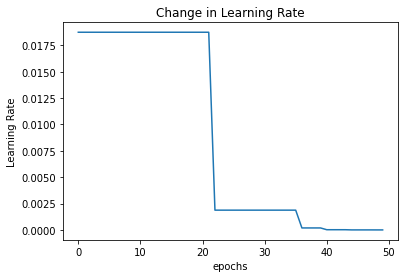

In [18]:
#Plotting LR
import matplotlib.pyplot as plt

lr_used = set(lr_list)
print(lr_used)

plt.plot(lr_list)
plt.title('Change in Learning Rate')
plt.xlabel('epochs')
plt.ylabel('Learning Rate')

In [19]:
import torch
best_model = CusResNet18().to('cuda')
best_model.load_state_dict(torch.load(gdrivepath + '/savedmodel/classifier.pt'))
best_model.eval()
print('Done')

Done


In [20]:
import plot as plot
import graphs as graphs

Directory  gdrive/My Drive/Colab Notebooks/S10//savedmodel/mis_class/  Created 
Directory  gdrive/My Drive/Colab Notebooks/S10//savedmodel/mis_class/images  Created 

Test set: Average loss: -19.0048, Accuracy: 9268/10000 (92.68%)

torch.Size([732, 3, 32, 32])


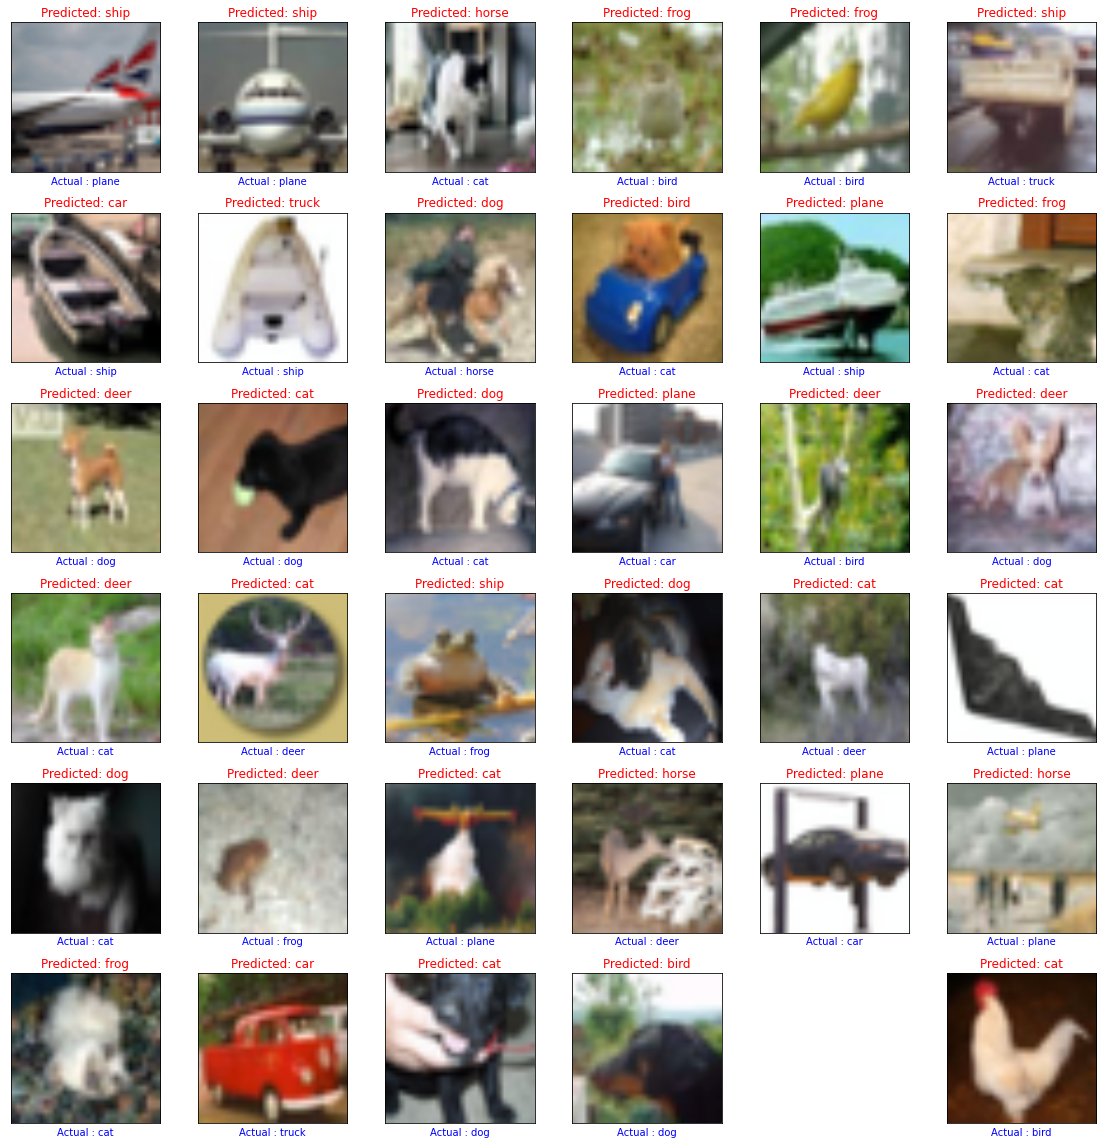

In [21]:
plot.mis(best_model, device, test_loader, 36)

In [22]:
len(plot.pred_list)

36

In [23]:
classes = plot.classes
pred_list = plot.pred_list
true_list = plot.true_list

In [24]:
layers = ['layer1', 'layer2', 'layer3', 'layer4']
for layer in layers:
  plot.gen_cam(best_model, layer, hm_lay=0.4, img_lay= 0.6) #Class idx defaulted to Predicted
  plot.gen_cam(best_model, layer, class_idx = true_list, hm_lay=0.4, img_lay= 0.6) #Setting Class idx to Actual Class

Directory  gdrive/My Drive/Colab Notebooks/S10//savedmodel/result_pred/  Created 
Directory  gdrive/My Drive/Colab Notebooks/S10//savedmodel/heatmap_pred/  Created 
Directory  gdrive/My Drive/Colab Notebooks/S10//savedmodel/result_act/  Created 
Directory  gdrive/My Drive/Colab Notebooks/S10//savedmodel/heatmap_act/  Created 


In [25]:
plot.plot_pred_cam(36, 4)

Output hidden; open in https://colab.research.google.com to view.

In [26]:
layers = ['layer1', 'layer2', 'layer3', 'layer4']
for layer in layers:
  plot.gen_cam(best_model, layer, class_idx = true_list)


In [27]:
plot.plot_act_cam(36,4)

Output hidden; open in https://colab.research.google.com to view.

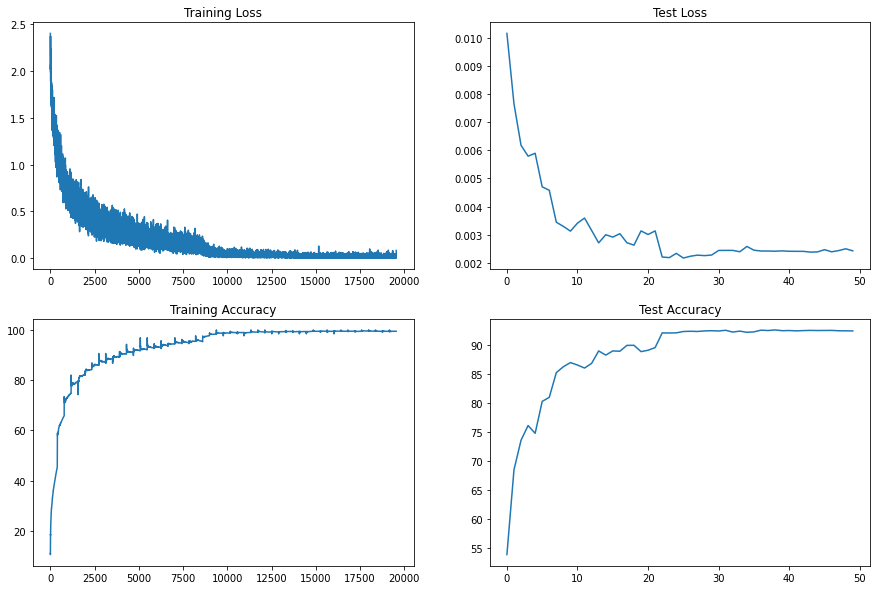

In [28]:
graphs.acc_loss(train, test)

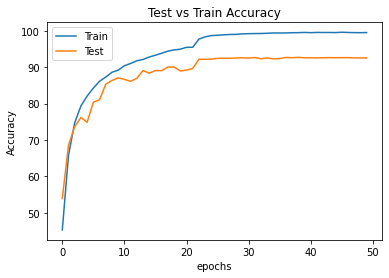

In [29]:
graphs.testvtrain(train, test)

In [30]:
graphs.class_acc(model, device, test_loader)

Accuracy of plane : 93 %
Accuracy of   car : 97 %
Accuracy of  bird : 89 %
Accuracy of   cat : 83 %
Accuracy of  deer : 92 %
Accuracy of   dog : 88 %
Accuracy of  frog : 95 %
Accuracy of horse : 93 %
Accuracy of  ship : 95 %
Accuracy of truck : 95 %


In [31]:
from train import Train
from test import Test
from torch.optim.lr_scheduler import ReduceLROnPlateau

model2 = CusResNet18().to(device)
optimizer2 = optim.SGD(model2.parameters(), lr= best_lr, momentum= 0.9)
criterion = nn.CrossEntropyLoss()
train2 = Train(model2, device, train_loader, optimizer2, criterion)
test2 = Test(model2, device, test_loader, criterion)
test_loss = test.test_loss
scheduler2 = ReduceLROnPlateau(optimizer2, mode='min', patience=3, verbose= True)

In [32]:
lr_list2 = []
epochs = 50
print('='*20 + 'START' + '='*20)
for epoch in range(epochs):
  print('='*20 + f' EPOCH: {epoch+1} ' + '='*20)
  train2.train(epoch)
  lr_list2.append(optimizer2.param_groups[0]['lr'])
  test2.test()
  scheduler2.step(test2.test_loss[-1]) #Have to give the val_loss or val_accuracy here. 
                                    #The metric on which we check reduction/increase 
                                    #and adjust learning rate

  0%|          | 0/391 [00:00<?, ?it/s]

====================START====================
==================== EPOCH: 1 ====================


Loss=0.9690591096878052 Batch_id=390 Accuracy=48.08: 100%|██████████| 391/391 [00:32<00:00, 12.06it/s]



Test set: Average loss: 0.0103, Accuracy: 5761/10000 (57.61%)



  0%|          | 0/391 [00:00<?, ?it/s]

==================== EPOCH: 2 ====================


Loss=0.7753691673278809 Batch_id=390 Accuracy=67.78: 100%|██████████| 391/391 [00:32<00:00, 12.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0077, Accuracy: 6878/10000 (68.78%)

==================== EPOCH: 3 ====================


Loss=0.6516059041023254 Batch_id=390 Accuracy=75.90: 100%|██████████| 391/391 [00:32<00:00, 12.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0066, Accuracy: 7381/10000 (73.81%)

==================== EPOCH: 4 ====================


Loss=0.3870600759983063 Batch_id=390 Accuracy=80.09: 100%|██████████| 391/391 [00:32<00:00, 12.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 7902/10000 (79.02%)

==================== EPOCH: 5 ====================


Loss=0.7819985151290894 Batch_id=390 Accuracy=82.76: 100%|██████████| 391/391 [00:32<00:00, 12.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8137/10000 (81.37%)

==================== EPOCH: 6 ====================


Loss=0.6646341681480408 Batch_id=390 Accuracy=84.58: 100%|██████████| 391/391 [00:32<00:00, 12.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8233/10000 (82.33%)

==================== EPOCH: 7 ====================


Loss=0.493757426738739 Batch_id=390 Accuracy=86.44: 100%|██████████| 391/391 [00:32<00:00, 11.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8214/10000 (82.14%)

==================== EPOCH: 8 ====================


Loss=0.5018972754478455 Batch_id=390 Accuracy=87.51: 100%|██████████| 391/391 [00:32<00:00, 11.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8279/10000 (82.79%)

==================== EPOCH: 9 ====================


Loss=0.38521042466163635 Batch_id=390 Accuracy=88.63: 100%|██████████| 391/391 [00:32<00:00, 12.02it/s]



Test set: Average loss: 0.0041, Accuracy: 8344/10000 (83.44%)



  0%|          | 0/391 [00:00<?, ?it/s]

==================== EPOCH: 10 ====================


Loss=0.4134894907474518 Batch_id=390 Accuracy=89.46: 100%|██████████| 391/391 [00:32<00:00, 11.96it/s]



Test set: Average loss: 0.0035, Accuracy: 8570/10000 (85.70%)



  0%|          | 0/391 [00:00<?, ?it/s]

==================== EPOCH: 11 ====================


Loss=0.23382127285003662 Batch_id=390 Accuracy=90.42: 100%|██████████| 391/391 [00:32<00:00, 11.99it/s]



Test set: Average loss: 0.0031, Accuracy: 8686/10000 (86.86%)



  0%|          | 0/391 [00:00<?, ?it/s]

==================== EPOCH: 12 ====================


Loss=0.1705416738986969 Batch_id=390 Accuracy=91.08: 100%|██████████| 391/391 [00:32<00:00, 11.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8701/10000 (87.01%)

==================== EPOCH: 13 ====================


Loss=0.24638450145721436 Batch_id=390 Accuracy=91.95: 100%|██████████| 391/391 [00:32<00:00, 12.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8729/10000 (87.29%)

==================== EPOCH: 14 ====================


Loss=0.20200590789318085 Batch_id=390 Accuracy=92.22: 100%|██████████| 391/391 [00:32<00:00, 12.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 8895/10000 (88.95%)

==================== EPOCH: 15 ====================


Loss=0.23355937004089355 Batch_id=390 Accuracy=92.97: 100%|██████████| 391/391 [00:32<00:00, 12.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8876/10000 (88.76%)

==================== EPOCH: 16 ====================


Loss=0.24285788834095 Batch_id=390 Accuracy=93.52: 100%|██████████| 391/391 [00:32<00:00, 12.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8857/10000 (88.57%)

==================== EPOCH: 17 ====================


Loss=0.33861690759658813 Batch_id=390 Accuracy=93.75: 100%|██████████| 391/391 [00:32<00:00, 12.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8844/10000 (88.44%)

==================== EPOCH: 18 ====================


Loss=0.19305238127708435 Batch_id=390 Accuracy=94.50: 100%|██████████| 391/391 [00:32<00:00, 11.96it/s]



Test set: Average loss: 0.0028, Accuracy: 8904/10000 (89.04%)



  0%|          | 0/391 [00:00<?, ?it/s]

==================== EPOCH: 19 ====================


Loss=0.20660480856895447 Batch_id=390 Accuracy=94.57: 100%|██████████| 391/391 [00:32<00:00, 11.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8872/10000 (88.72%)

==================== EPOCH: 20 ====================


Loss=0.17724323272705078 Batch_id=390 Accuracy=94.91: 100%|██████████| 391/391 [00:32<00:00, 11.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8858/10000 (88.58%)

==================== EPOCH: 21 ====================


Loss=0.17991051077842712 Batch_id=390 Accuracy=95.42: 100%|██████████| 391/391 [00:32<00:00, 11.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8784/10000 (87.84%)

==================== EPOCH: 22 ====================


Loss=0.1863146871328354 Batch_id=390 Accuracy=95.80: 100%|██████████| 391/391 [00:32<00:00, 11.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 8951/10000 (89.51%)

Epoch    22: reducing learning rate of group 0 to 1.8738e-03.
==================== EPOCH: 23 ====================


Loss=0.06918085366487503 Batch_id=390 Accuracy=97.74: 100%|██████████| 391/391 [00:32<00:00, 12.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9213/10000 (92.13%)

==================== EPOCH: 24 ====================


Loss=0.048040758818387985 Batch_id=390 Accuracy=98.47: 100%|██████████| 391/391 [00:32<00:00, 12.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9216/10000 (92.16%)

==================== EPOCH: 25 ====================


Loss=0.07529396563768387 Batch_id=390 Accuracy=98.67: 100%|██████████| 391/391 [00:32<00:00, 11.97it/s]



Test set: Average loss: 0.0021, Accuracy: 9226/10000 (92.26%)



  0%|          | 0/391 [00:00<?, ?it/s]

==================== EPOCH: 26 ====================


Loss=0.02097884565591812 Batch_id=390 Accuracy=98.73: 100%|██████████| 391/391 [00:32<00:00, 11.95it/s]



Test set: Average loss: 0.0022, Accuracy: 9227/10000 (92.27%)



  0%|          | 0/391 [00:00<?, ?it/s]

==================== EPOCH: 27 ====================


Loss=0.06539922207593918 Batch_id=390 Accuracy=98.77: 100%|██████████| 391/391 [00:32<00:00, 11.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9221/10000 (92.21%)

==================== EPOCH: 28 ====================


Loss=0.021558020263910294 Batch_id=390 Accuracy=99.00: 100%|██████████| 391/391 [00:32<00:00, 12.09it/s]



Test set: Average loss: 0.0022, Accuracy: 9234/10000 (92.34%)



  0%|          | 0/391 [00:00<?, ?it/s]

==================== EPOCH: 29 ====================


Loss=0.01726451888680458 Batch_id=390 Accuracy=99.01: 100%|██████████| 391/391 [00:32<00:00, 12.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9244/10000 (92.44%)

Epoch    29: reducing learning rate of group 0 to 1.8738e-04.
==================== EPOCH: 30 ====================


Loss=0.019682597368955612 Batch_id=390 Accuracy=99.10: 100%|██████████| 391/391 [00:32<00:00, 12.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9245/10000 (92.45%)

==================== EPOCH: 31 ====================


Loss=0.07478775084018707 Batch_id=390 Accuracy=99.21: 100%|██████████| 391/391 [00:32<00:00, 12.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9243/10000 (92.43%)

==================== EPOCH: 32 ====================


Loss=0.024877119809389114 Batch_id=390 Accuracy=99.14: 100%|██████████| 391/391 [00:32<00:00, 12.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9236/10000 (92.36%)

==================== EPOCH: 33 ====================


Loss=0.01627485826611519 Batch_id=390 Accuracy=99.16: 100%|██████████| 391/391 [00:32<00:00, 12.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9234/10000 (92.34%)

Epoch    33: reducing learning rate of group 0 to 1.8738e-05.
==================== EPOCH: 34 ====================


Loss=0.026742015033960342 Batch_id=390 Accuracy=99.17: 100%|██████████| 391/391 [00:32<00:00, 12.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9243/10000 (92.43%)

==================== EPOCH: 35 ====================


Loss=0.03356577828526497 Batch_id=390 Accuracy=99.17: 100%|██████████| 391/391 [00:32<00:00, 12.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9244/10000 (92.44%)

==================== EPOCH: 36 ====================


Loss=0.011614963412284851 Batch_id=390 Accuracy=99.17: 100%|██████████| 391/391 [00:32<00:00, 12.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9233/10000 (92.33%)

==================== EPOCH: 37 ====================


Loss=0.013610346242785454 Batch_id=390 Accuracy=99.15: 100%|██████████| 391/391 [00:32<00:00, 12.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9233/10000 (92.33%)

Epoch    37: reducing learning rate of group 0 to 1.8738e-06.
==================== EPOCH: 38 ====================


Loss=0.047781359404325485 Batch_id=390 Accuracy=99.21: 100%|██████████| 391/391 [00:32<00:00, 12.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9238/10000 (92.38%)

==================== EPOCH: 39 ====================


Loss=0.02721681259572506 Batch_id=390 Accuracy=99.22: 100%|██████████| 391/391 [00:32<00:00, 12.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9232/10000 (92.32%)

==================== EPOCH: 40 ====================


Loss=0.05628657341003418 Batch_id=390 Accuracy=99.12: 100%|██████████| 391/391 [00:32<00:00, 12.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9241/10000 (92.41%)

==================== EPOCH: 41 ====================


Loss=0.10671279579401016 Batch_id=390 Accuracy=99.17: 100%|██████████| 391/391 [00:32<00:00, 12.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9233/10000 (92.33%)

Epoch    41: reducing learning rate of group 0 to 1.8738e-07.
==================== EPOCH: 42 ====================


Loss=0.053381264209747314 Batch_id=390 Accuracy=99.26: 100%|██████████| 391/391 [00:32<00:00, 12.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9240/10000 (92.40%)

==================== EPOCH: 43 ====================


Loss=0.008235613815486431 Batch_id=390 Accuracy=99.22: 100%|██████████| 391/391 [00:32<00:00, 12.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9239/10000 (92.39%)

==================== EPOCH: 44 ====================


Loss=0.0192708820104599 Batch_id=390 Accuracy=99.22: 100%|██████████| 391/391 [00:32<00:00, 12.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9249/10000 (92.49%)

==================== EPOCH: 45 ====================


Loss=0.014454184100031853 Batch_id=390 Accuracy=99.25: 100%|██████████| 391/391 [00:32<00:00, 12.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9239/10000 (92.39%)

Epoch    45: reducing learning rate of group 0 to 1.8738e-08.
==================== EPOCH: 46 ====================


Loss=0.020062636584043503 Batch_id=390 Accuracy=99.22: 100%|██████████| 391/391 [00:32<00:00, 12.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9241/10000 (92.41%)

==================== EPOCH: 47 ====================


Loss=0.026241417974233627 Batch_id=390 Accuracy=99.18: 100%|██████████| 391/391 [00:32<00:00, 11.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9235/10000 (92.35%)

==================== EPOCH: 48 ====================


Loss=0.007084069307893515 Batch_id=390 Accuracy=99.17: 100%|██████████| 391/391 [00:32<00:00, 11.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9234/10000 (92.34%)

==================== EPOCH: 49 ====================


Loss=0.027145076543092728 Batch_id=390 Accuracy=99.14: 100%|██████████| 391/391 [00:32<00:00, 12.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9239/10000 (92.39%)

Epoch    49: reducing learning rate of group 0 to 1.8738e-09.
==================== EPOCH: 50 ====================


Loss=0.06297145783901215 Batch_id=390 Accuracy=99.25: 100%|██████████| 391/391 [00:32<00:00, 12.09it/s]



Test set: Average loss: 0.0023, Accuracy: 9243/10000 (92.43%)



{0.01873817422860384, 1.8738174228603845e-09, 1.8738174228603844e-08, 1.8738174228603844e-06, 1.8738174228603844e-05, 1.8738174228603844e-07, 0.0018738174228603841, 0.00018738174228603844}


Text(0, 0.5, 'Learning Rate')

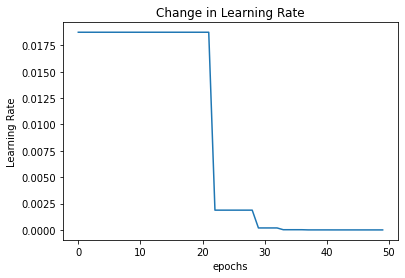

In [33]:
#Plotting LR
import matplotlib.pyplot as plt

lr_used2 = set(lr_list2)
print(lr_used2)

plt.plot(lr_list2)
plt.title('Change in Learning Rate')
plt.xlabel('epochs')
plt.ylabel('Learning Rate')

In [36]:
!ls

augmentation.py  datasets.py	  gdrive      plot.py	   sample_data
CusResNet.py	 data_summary.py  gradCAM.py  __pycache__  test.py
data.py		 find_lr.py	  graphs.py   root	   train.py
